# Презентация

<https://disk.yandex.ru/i/vE9o1tro54P0AQ>

# Декомпозиция проекта «Анализ влияния пользовательских действий на просмотр контактов»

## Задачи
- Проанализировать связь целевого события — просмотра контактов — и других действий пользователей.
- Оценить, какие действия чаще совершают те пользователи, которые просматривают контакты.

## Этапы исследования
1. Предобработка данных:
   - Загрузка и обзор данных, работа с дубликатами и отсутствующими значениями.
2. Исследовательский анализ данных:
   - Визуализация данных, выявление в них взаимосвязей и интересных для бизнеса особенностей.
3. Проанализировать влияние событий на совершение целевого события:
   - В разрезе сессий отобрать сценарии/паттерны, которые приводят к просмотру контактов.
   - Построить воронки по основным сценариям в разрезе уникальных пользователей.
   - Посмотреть, как различается длительность сессий с ***contacts_show*** и без.
   - Рассчитать относительную частоту событий в разрезе двух групп пользователей: группа пользователей, которые **смотрели** контакты ***contacts_show*** и которые **не смотрели**.
7. Проверить статистическию гипотезу о различии конверсии в просмотры контактов у пользователей, которые совершают действия ***tips_show*** и ***tips_click***, и тех, кто совершает только ***tips_show***.
8. Проверить статистическую гипотезу о различии конверсии в целевое действие у пользователей, которые пришли из поисковых источников (***yandex***, ***google***) и непоисковых (***other***).
9. Выводы и рекомендации.

# 1. Предобработка данных

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import re
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Загружаем данные
profiles = pd.read_csv('mobile_sources.csv')
sessions = pd.read_csv('mobile_dataset.csv', parse_dates=['event.time'])

In [3]:
# Задаём названиям колонок змеиный регистр
profiles.rename(columns={'userId': 'user_id'}, inplace=True)
sessions.columns = ['event_time', 'event_name', 'user_id']

In [4]:
profiles

user_id  source
0     020292ab-89bc-4156-9acf-68bc2783f894   other
1     cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2     8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3     d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4     f32e1e2a-3027-4693-b793-b7b3ff274439  google
...                                    ...     ...
4288  b86fe56e-f2de-4f8a-b192-cd89a37ecd41  yandex
4289  424c0ae1-3ea3-4f1e-a814-6bac73e48ab1  yandex
4290  437a4cd4-9ba9-457f-8614-d142bc48fbeb  yandex
4291  c10055f0-0b47-477a-869e-d391b31fdf8f  yandex
4292  d157bffc-264d-4464-8220-1cc0c42f43a9  google

[4293 rows x 2 columns]

In [5]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [6]:
sessions

event_time   event_name  \
0     2019-10-07 00:00:00.431357  advert_open   
1     2019-10-07 00:00:01.236320    tips_show   
2     2019-10-07 00:00:02.245341    tips_show   
3     2019-10-07 00:00:07.039334    tips_show   
4     2019-10-07 00:00:56.319813  advert_open   
...                          ...          ...   
74192 2019-11-03 23:53:29.534986    tips_show   
74193 2019-11-03 23:54:00.407086    tips_show   
74194 2019-11-03 23:56:57.041825     search_1   
74195 2019-11-03 23:57:06.232189    tips_show   
74196 2019-11-03 23:58:12.532487    tips_show   

                                    user_id  
0      020292ab-89bc-4156-9acf-68bc2783f894  
1      020292ab-89bc-4156-9acf-68bc2783f894  
2      cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3      020292ab-89bc-4156-9acf-68bc2783f894  
4      cf7eda61-9349-469f-ac27-e5b6f5ec475c  
...                                     ...  
74192  28fccdf4-7b9e-42f5-bc73-439a265f20e9  
74193  28fccdf4-7b9e-42f5-bc73-439a265f20e9  
74194  20850c8f-4135-4059-b13b-198d3ac59902  
74195  28fccdf4-7b9e-42f5-bc73-439a265f20e9  
74196  28fccdf4-7b9e-42f5-bc73-439a265f20e9  

[74197 rows x 3 columns]

In [7]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


In [8]:
# Проверим размерность датасетов
for name, df in ('profiles', profiles), ('sessions', sessions):
    print(f'Размер (количество строк, количество столбцов) датасета {name}:', df.shape)
    print(f'Столбцы:, {df.columns.tolist()}\n')

Размер (количество строк, количество столбцов) датасета profiles: (4293, 2)
Столбцы:, ['user_id', 'source']

Размер (количество строк, количество столбцов) датасета sessions: (74197, 3)
Столбцы:, ['event_time', 'event_name', 'user_id']



In [9]:
# Преобразуем данные в 'event_time'
sessions['event_time'] = pd.to_datetime(sessions['event_time']).dt.round('1s')

In [10]:
# Объединяем значения search_1 – search_7
sessions['event_name'] = sessions['event_name'].apply(lambda x: re.sub(r'search_\d+', 'search', x))

In [11]:
# Объединим show_contacts и contacts_show
sessions['event_name'].replace({'show_contacts': 'contacts_show'}, inplace=True)

In [12]:
# Проверим датасеты на наличие явных дубликатов
for name, df in ('profiles', profiles), ('sessions', sessions):
    print(f'Датасет {name}')
    print(f'{df.isna().sum()}\n')

Датасет profiles
user_id    0
source     0
dtype: int64

Датасет sessions
event_time    0
event_name    0
user_id       0
dtype: int64



In [13]:
# Проверим наличие неявных дубликатов в столбцах 'source' и 'event_name'
print(f"'source': {profiles['source'].unique()}\n")
print(f"'event_name': {sessions['event_name'].unique()}")

'source': ['other' 'yandex' 'google']

'event_name': ['advert_open' 'tips_show' 'map' 'contacts_show' 'search' 'tips_click'
 'photos_show' 'favorites_add' 'contacts_call']


В Яндекс Метрики тайм-аут визита (сессии) по умолчанию [составляет](https://yandex.ru/support/metrica/general/counter-general.html#counter-general__time-out:~:text=%D0%A2%D0%B0%D0%B9%D0%BC%2D%D0%B0%D1%83%D1%82%20%D0%B2%D0%B8%D0%B7%D0%B8%D1%82%D0%B0,%D1%81%D0%BE%D1%81%D1%82%D0%B0%D0%B2%D0%BB%D1%8F%D0%B5%D1%82%C2%A030%C2%A0%D0%BC%D0%B8%D0%BD%D1%83%D1%82.) 30 минут. В Google Analytics длительность сеанса (визита) по умолчанию — [так же](https://support.google.com/analytics/answer/9191807?hl=ru#zippy=:~:text=%D0%9F%D0%BE%20%D1%83%D0%BC%D0%BE%D0%BB%D1%87%D0%B0%D0%BD%D0%B8%D1%8E%20%D1%81%D0%B5%D0%B0%D0%BD%D1%81%20%D0%B7%D0%B0%D0%B2%D0%B5%D1%80%D1%88%D0%B0%D0%B5%D1%82%D1%81%D1%8F%20%D1%87%D0%B5%D1%80%D0%B5%D0%B7%2030%20%D0%BC%D0%B8%D0%BD%D1%83%D1%82%20%D0%B1%D0%B5%D0%B7%D0%B4%D0%B5%D0%B9%D1%81%D1%82%D0%B2%D0%B8%D1%8F.%20%D0%94%D0%BB%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C%20%D1%81%D0%B5%D0%B0%D0%BD%D1%81%D0%B0%20%D0%BF%D1%80%D0%B8%20%D1%8D%D1%82%D0%BE%D0%BC%20%D0%BD%D0%B5%20%D0%BE%D0%B3%D1%80%D0%B0%D0%BD%D0%B8%D1%87%D0%B5%D0%BD%D0%B0.) 30 минут.

Будем отталкиваться о того, что тайм-аут сессии установлен по умолчанию в 30 минут.

In [14]:
# Сортируем sessions по 'user_id' и 'event_time'
sessions.sort_values(['user_id', 'event_time'], inplace=True)

# Группируем по тайм-ауту сессии в 30 минут как в Метрике и GA
get_sessions = (
    sessions
    .groupby('user_id')['event_time']
    .diff() >= pd.Timedelta('30Min') # Проверяем, превышает ли разница между событиями 30 минут
).cumsum() # Применяем кумулятивную сумму для создания уникальных сессий

# Формируем колонку 'session_id'
sessions['session_id'] = (
    sessions
    .groupby(['user_id', get_sessions], sort=False)
    .ngroup() + 1
)

In [15]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74197 entries, 805 to 72689
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   session_id  74197 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.8+ MB


# Результаты предобработки данных
В датасетах не было обнаружено пропусков и дубликатов. Столбцы приведены к соответствующим типам данных, их названия к змеиному стилю. Размерность датасетов проверена, значения преобразованы к нужному виду. Были выделены сессии и записаны в столбец ***'session_id'***.

# 2. Исследовательский анализ данных

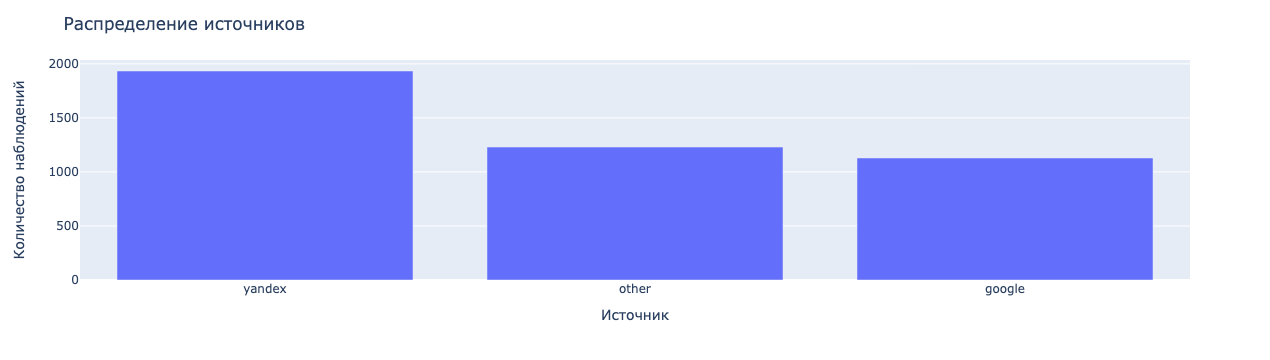

In [16]:
# Посчитаем поличество переходов из каждого источника
source_counts = profiles['source'].value_counts()

fig = px.bar(source_counts, x=source_counts.index, y=source_counts.values)
fig.update_layout(
    title='Распределение источников', xaxis_title='Источник', yaxis_title='Количество наблюдений'
)
fig.show()

Чаще всего пользователи приходят в приложение из Яндекса. Затем идут other и Google практически с полуторным отставанием.

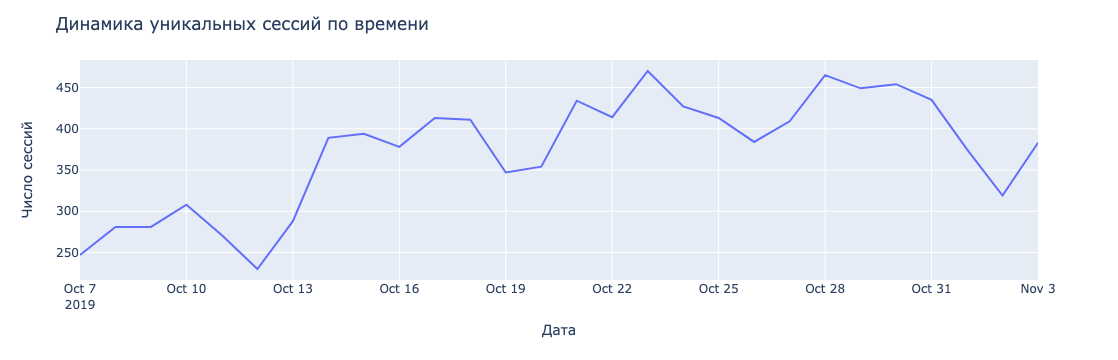

In [17]:
# Группируем данные по дате и количеству уникальных сессий
sessions_by_date = sessions.groupby(sessions['event_time'].dt.date)['session_id'].nunique().reset_index()
sessions_by_date.columns = ['date', 'session_count']

fig = px.line(sessions_by_date, x='date', y='session_count')
fig.update_layout(
    title='Динамика уникальных сессий по времени', xaxis_title='Дата', yaxis_title='Число сессий'
)
fig.show()

Начиная со старта наблюдений начинается рост числа уникальных сессий, продолжающийся до конца наблюдений. На графике видно четыре точки спада, которые, возможно, могут быть выходными днями, когда пользовательская активность в приложении ниже.

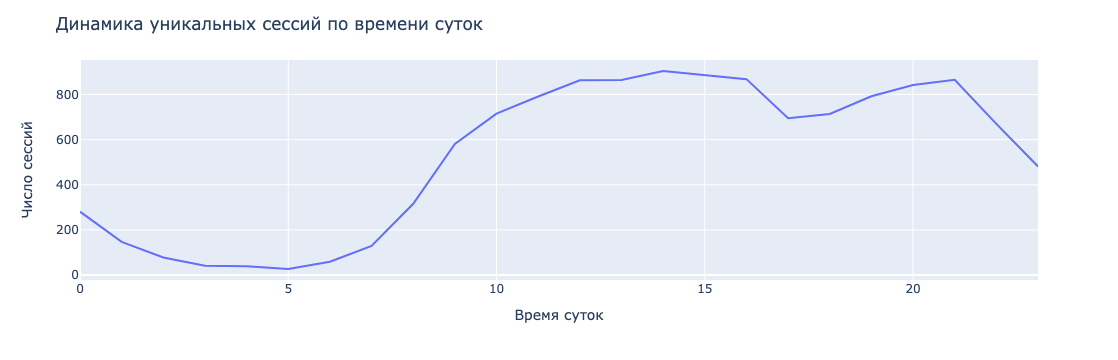

In [18]:
# Создадим колонку 'hour'
sessions['hour'] = sessions['event_time'].dt.hour

# Сгруппируем данные по новому столбцу и количеству уникальных сессий
sessions_by_hour = sessions.groupby('hour')['session_id'].nunique().reset_index()
sessions_by_hour.columns = ['hour', 'sessions']

fig = px.line(sessions_by_hour, x='hour', y='sessions')
fig.update_layout(
    title='Динамика уникальных сессий по времени суток', xaxis_title='Время суток', yaxis_title='Число сессий'
)
fig.show()

В течение дня число сессий активно растёт с 7:00, достигая в 14:00 пикового значения. После чего количество сессий постепенно уменьшается, возобновляя рост в 18:00, который выходит на пиковую отметку в 21:00, а затем начинает резкое снижение до 5:00.

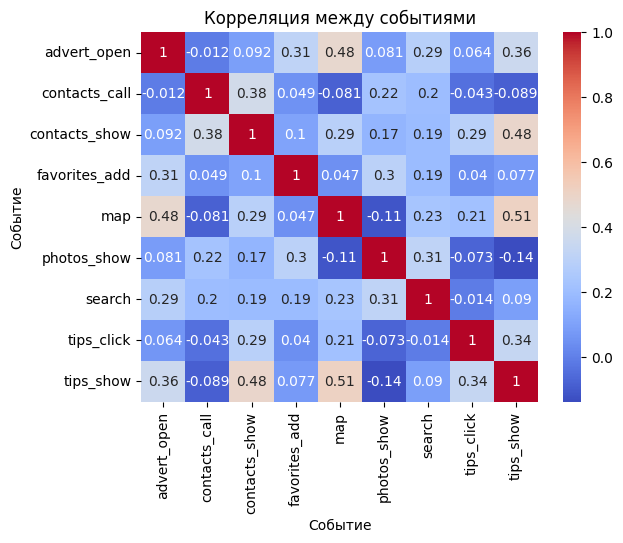

In [19]:
# Создаём кросс-таблицу с количеством событий
event_counts = (
    sessions
    .groupby(['user_id', 'event_name']).nunique()
    .pivot_table(index='user_id', columns='event_name', values='session_id', fill_value=0)
)

# Вычисляем корреляцию между событиями
event_corr = event_counts.corr()

sns.heatmap(event_corr, annot=True, cmap='coolwarm')
plt.title('Корреляция между событиями')
plt.xlabel('Событие')
plt.ylabel('Событие')
plt.show()

Достаточно высокие положительные корреляции наблюдаются между ***'map'*** и ***'advert_open'***, *'map'* и ***'contacts_show'***, *'map'* и ***'photos_show'***, *'map'* и ***'tips_show'***. Пользователи, которые пользуются картой, часто также открывают объявления, просматривают контакты, фотографии и смотрят рекомендации. Можно говорить о том, что эти события связаны.

С другой стороны, события ***'contacts_call'*** и ***'tips_show'*** имеют отрицательную корреляцию, что может указывать на то, что пользователи, которые звонят по объявлению, реже смотрят рекомендации, и наоборот.

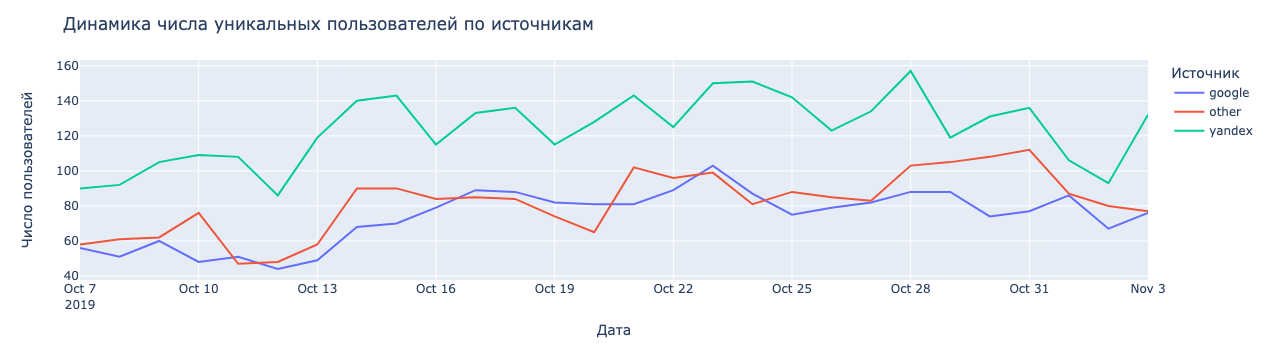

In [20]:
# Объединяем profiles и sessions
data = pd.merge(sessions, profiles, on='user_id')
data['event_time'] = pd.to_datetime(data['event_time'])

# Группируем данные по источнику и дате, считаем уникальных пользователей
users_by_source_and_date = data.groupby(['source', data['event_time'].dt.date])['user_id'].nunique().reset_index()
users_by_source_and_date.columns = ['source', 'date', 'user_count']

fig = px.line(users_by_source_and_date, x='date', y='user_count', color='source')
fig.update_layout(
    title='Динамика числа уникальных пользователей по источникам',
    xaxis_title='Дата', yaxis_title='Число пользователей', legend_title='Источник'
)
fig.show()

На графике динамики по источникам видна общая линия тренда на увеличение числа уникальных пользователей за сутки, доминирование **Яндекса** и борьбу за второе место между **other** и **Google**.

In [33]:
data.to_csv('merged_data.csv', index=False)

In [41]:
np.sort(data['event_time'].dt.date.unique())

array([datetime.date(2019, 10, 7), datetime.date(2019, 10, 8),
       datetime.date(2019, 10, 9), datetime.date(2019, 10, 10),
       datetime.date(2019, 10, 11), datetime.date(2019, 10, 12),
       datetime.date(2019, 10, 13), datetime.date(2019, 10, 14),
       datetime.date(2019, 10, 15), datetime.date(2019, 10, 16),
       datetime.date(2019, 10, 17), datetime.date(2019, 10, 18),
       datetime.date(2019, 10, 19), datetime.date(2019, 10, 20),
       datetime.date(2019, 10, 21), datetime.date(2019, 10, 22),
       datetime.date(2019, 10, 23), datetime.date(2019, 10, 24),
       datetime.date(2019, 10, 25), datetime.date(2019, 10, 26),
       datetime.date(2019, 10, 27), datetime.date(2019, 10, 28),
       datetime.date(2019, 10, 29), datetime.date(2019, 10, 30),
       datetime.date(2019, 10, 31), datetime.date(2019, 11, 1),
       datetime.date(2019, 11, 2), datetime.date(2019, 11, 3)],
      dtype=object)

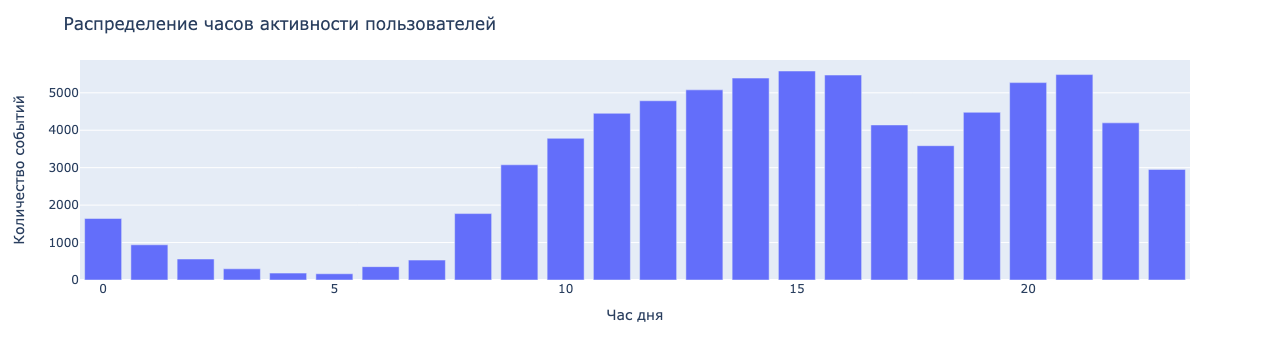

In [21]:
# Группируем данные по часу и подсчитываем количество событий
hourly_event_counts = data.groupby('hour')['event_name'].count().reset_index()

fig = px.bar(hourly_event_counts, x='hour', y='event_name')
fig.update_layout(
    title='Распределение часов активности пользователей', xaxis_title='Час дня', yaxis_title='Количество событий'
)
fig.show()

Здесь более наглядно видны пиковые часы — 15:00 и 21:00.

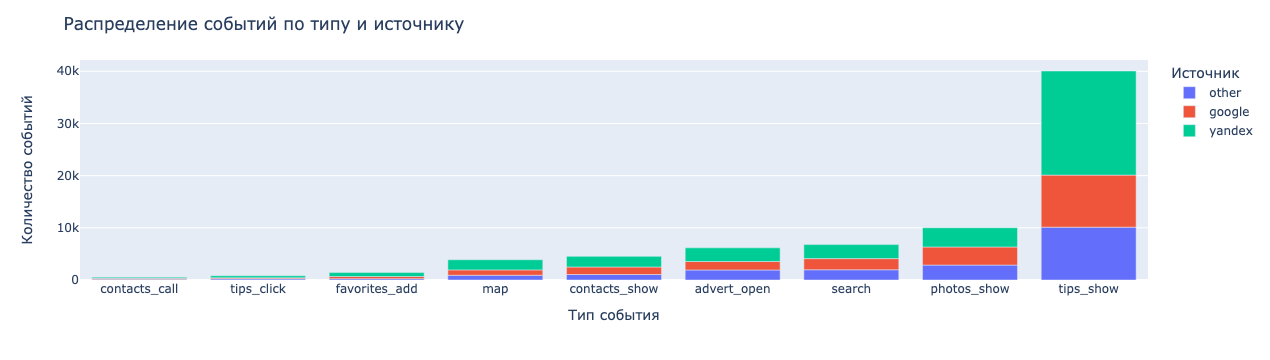

In [22]:
# Группируем данные по типу события и источнику
event_source_counts = data.groupby(['event_name', 'source'])['user_id'].count().sort_values().reset_index()

fig = px.bar(
    event_source_counts, x='event_name', y='user_id', color='source'
)
fig.update_layout(
    title='Распределение событий по типу и источнику', xaxis_title='Тип события', yaxis_title='Количество событий', legend_title='Источник'
)
fig.show()

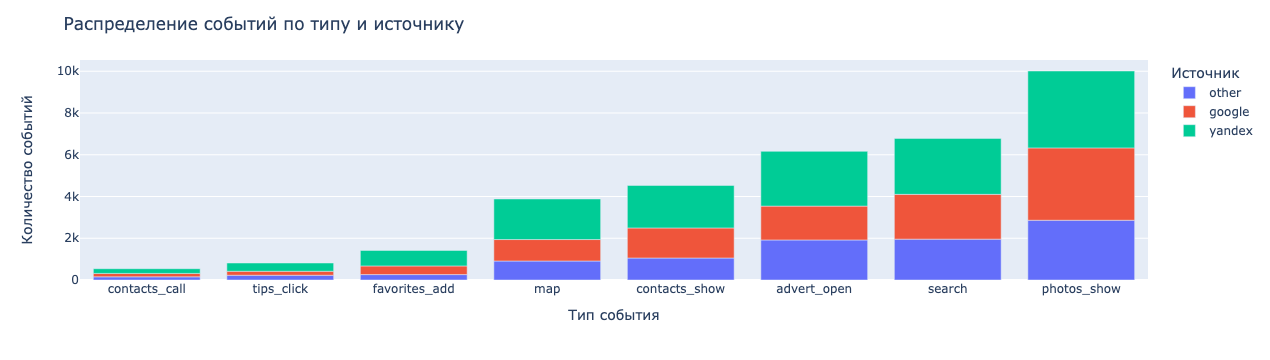

In [23]:
fig = px.bar(
    event_source_counts[:-3], x='event_name', y='user_id', color='source'
)
fig.update_layout(
    title='Распределение событий по типу и источнику', xaxis_title='Тип события', yaxis_title='Количество событий', legend_title='Источник'
)
fig.show()

***'tips_show'*** — самое популярное событие. Следом идёт ***'photos_show'***, ***'search'*** и ***'advert_open'***. На первый взгляд, кроме *'tips_show'*, типы событий распределены по источникам примерно в равных пропорциях.

# Анализ влияния событий на совершение целевого события

In [24]:
# Уберём повторяющиеся события в рамках сессии
filtred_sessions = data.drop_duplicates(subset=['session_id', 'event_name'])

# Сгруппируем данные по сессии и создадим кортежи сценариев
scenarios = filtred_sessions.groupby('session_id')['event_name'].apply(list).reset_index()

# Отфильтруем по сценариям с contacts_show в конце
scenarios = scenarios[scenarios['event_name'].apply(lambda x: x[-1] == 'contacts_show')].reset_index(drop=True)
scenarios = scenarios['event_name'].value_counts().reset_index()
scenarios.columns = ['scenario', 'count']
scenarios.head()

scenario  count
0       [tips_show, contacts_show]    342
1                  [contacts_show]    195
2  [map, tips_show, contacts_show]     94
3     [photos_show, contacts_show]     85
4          [search, contacts_show]     52

Построим воронки для пяти самых популряных сценариев.

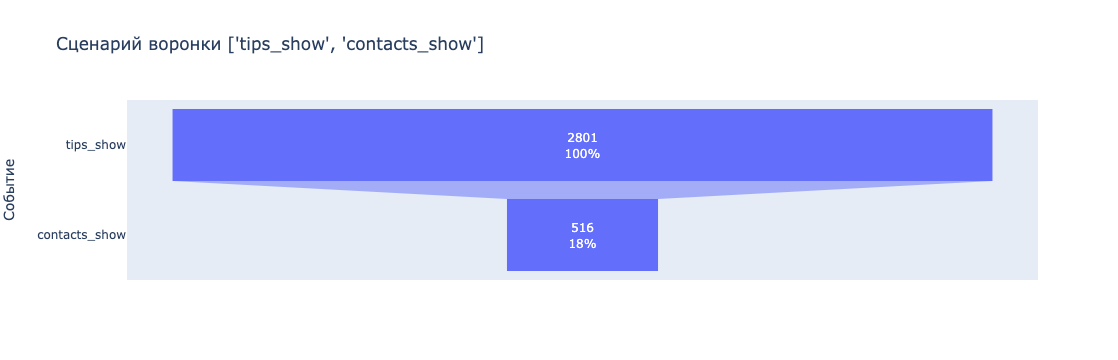

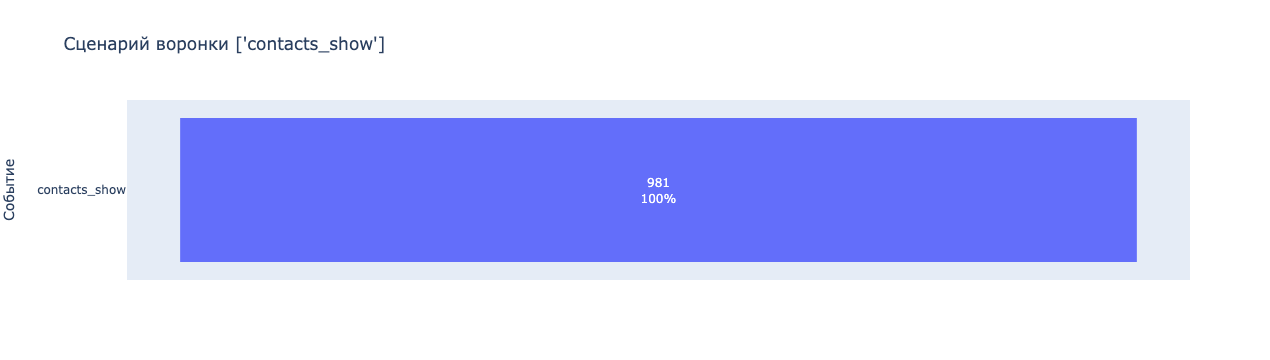

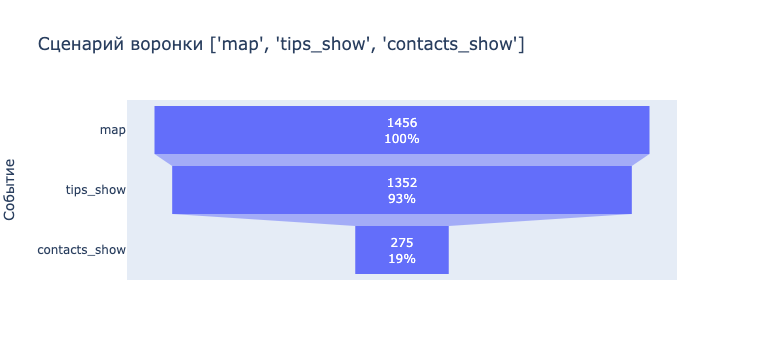

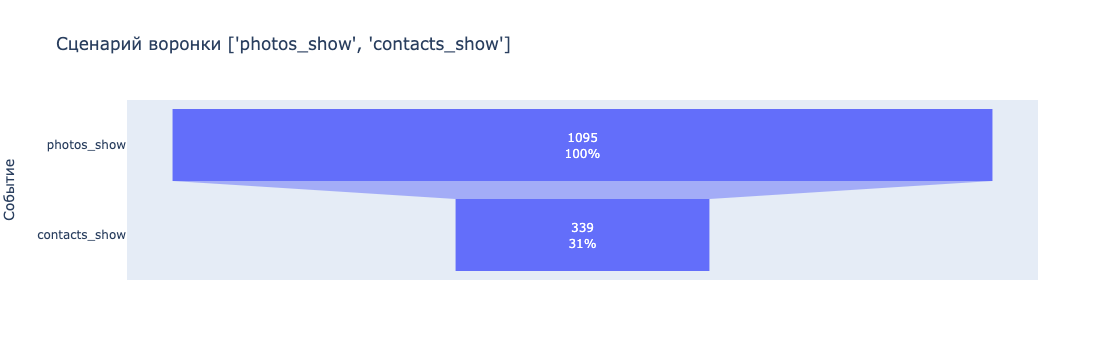

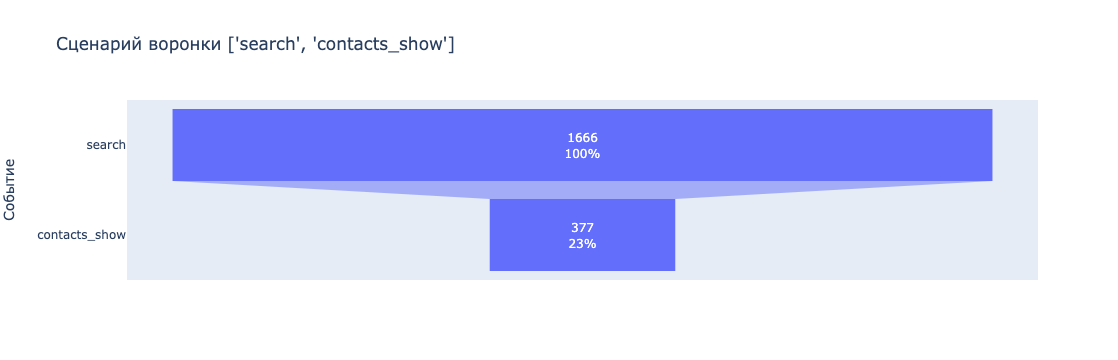

In [25]:
# Объявим функцию для расчёта

def scenario_funnel(filtred_sessions, events):
    
    # Создаём пустой список для хранения количества на каждом этапе
    funnel_counts = []
    # Инициализируем как None, чтобы хранить идентификаторы пользователей
    user_ids = None
    
    for event in events:
        # Находим уникальных пользователей, совершивших событие
        event_users = filtred_sessions[filtred_sessions['event_name'] == event]['user_id'].unique()
        # Если user_ids пустое (первое событие)
        if user_ids is None:
            # Сохраняем в него идентификаторы пользователей
            user_ids = set(event_users)
        # Иначе находим пересечение текущего набора пользователей и пользователей из предыдущих событий
        else:
            user_ids = user_ids.intersection(event_users)
        # Добавляем количество пользователей на текущем этапе в воронке
        funnel_counts.append(len(user_ids))

    return funnel_counts

# Объявим функцию для построения графиков

def plot_scenarios_as_funnels(filtred_sessions, scenarios):
    for index, row in scenarios.head().iterrows():
        scenario = row['scenario']

        fig = go.Figure(go.Funnel(
            y=scenario, x=scenario_funnel(filtred_sessions, scenario), textinfo='value+percent initial'
        ))
        fig.update_layout(
            title=f'Сценарий воронки {scenario}', xaxis_title='Число уникальных пользователей', yaxis_title='Событие'
        )
        fig.show()

plot_scenarios_as_funnels(filtred_sessions, scenarios.head())

Больше всего уникальных пользователей дошли до целевого действия через прямой сценарий, состоящий только из contacts_show, — 981 юзер. В процентном отношении лучший результат у сценария photos_show — contacts_show — целевое действие совершили 31% уникальных пользователей от первого шага. Среди хотя бы двухуровневых воронок лучший результат у сценария tips_show — contacts_show — 516 уникальных пользователей.

Посмотрим, отличается ли средняя длительность сессии с целевым действием 'contacts_show' и без.

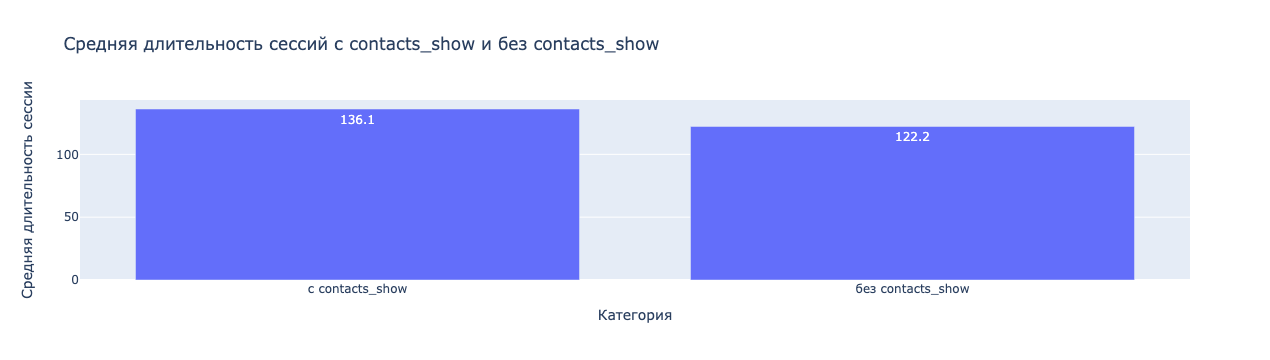

In [26]:
# Создадим столбец 'session_duration' для записи длительности сессий
data['session_duration'] = data.groupby('session_id')['event_time'].diff().dt.total_seconds()

# Настроим фильтр, который оставит только те сессии, в которых нет события 'contacts_show' и в которых есть
sessions_no_contacts = data[~data['session_id'].isin(data[data['event_name'] == 'contacts_show']['session_id'])]
sessions_contacts = data[data['session_id'].isin(data[data['event_name'] == 'contacts_show']['session_id'])]

# Найдём среднюю длительность сессий с 'contacts_show' и без
avg_duration_no_contacts = round(sessions_no_contacts['session_duration'].mean(), 1)
avg_duration_contacts = round(sessions_contacts['session_duration'].mean(), 1)

# Создадим датафрейм для значений средних длительностей сессий
avg_sessions = pd.DataFrame({
    'Категория': ['с contacts_show', 'без contacts_show'],
    'Средняя длительность сессии': [avg_duration_contacts, avg_duration_no_contacts]
})

fig = px.bar(
    avg_sessions, x='Категория', y='Средняя длительность сессии',
    text='Средняя длительность сессии', title='Средняя длительность сессий с contacts_show и без contacts_show'
)
fig.show()

В среднем сессии с 'contacts_show' на 13.9 секунд или 11% дольше, чем без 'contacts_show'.

Теперь рассчитаем относительную частоту событий в разрезе двух групп пользователей — группа пользователей, которые смотрели контакты contacts_show и которые не смотрели.

In [27]:
# Посчитаем общее количество событий для каждой группы
total_events_contacts = len(sessions_contacts)
total_events_no_contacts = len(sessions_no_contacts)

# Группируем события по названию и подсчитываем их количество в каждой группе
event_counts_contacts = sessions_contacts['event_name'].value_counts().reset_index()
event_counts_no_contacts = sessions_no_contacts['event_name'].value_counts().reset_index()

# Переименовываем столбцы
event_counts_contacts.columns = ['event_name', 'count_contacts']
event_counts_no_contacts.columns = ['event_name', 'count_no_contacts']

# Объединяем данные
merged_event_counts = event_counts_contacts.merge(event_counts_no_contacts, on='event_name', how='outer')

# Заполняем пропуски нулями
merged_event_counts.fillna(0, inplace=True)

# Рассчитываем относительную частоту событий
merged_event_counts['freq_contacts'] = round(merged_event_counts['count_contacts'] / total_events_contacts, 2)
merged_event_counts['freq_no_contacts'] = round(merged_event_counts['count_no_contacts'] / total_events_no_contacts, 2)

merged_event_counts

event_name  count_contacts  count_no_contacts  freq_contacts  \
0      tips_show            7509            32546.0           0.45   
1  contacts_show            4529                0.0           0.27   
2    photos_show            1594             8418.0           0.09   
3         search             908             5876.0           0.05   
4    advert_open             777             5387.0           0.05   
5  contacts_call             541                0.0           0.03   
6            map             514             3367.0           0.03   
7  favorites_add             251             1166.0           0.01   
8     tips_click             189              625.0           0.01   

   freq_no_contacts  
0              0.57  
1              0.00  
2              0.15  
3              0.10  
4              0.09  
5              0.00  
6              0.06  
7              0.02  
8              0.01

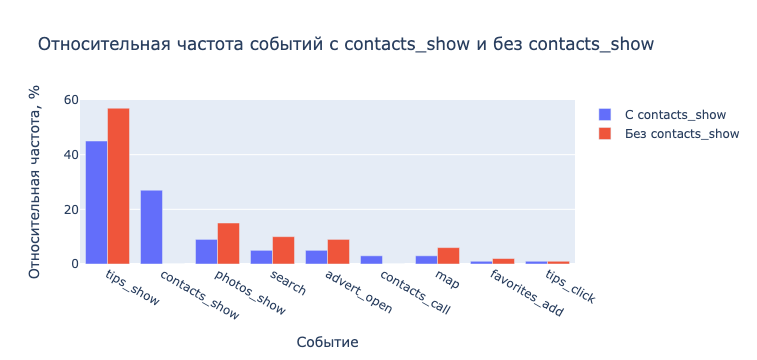

In [28]:
# Создадим графики для обеих групп
fig = go.Figure(data=[
    go.Bar(
        x=merged_event_counts['event_name'], y=merged_event_counts['freq_contacts'] * 100, name='С contacts_show'
    ),
    go.Bar(
        x=merged_event_counts['event_name'], y=merged_event_counts['freq_no_contacts'] * 100, name='Без contacts_show'
    )
])
fig.update_layout(barmode='group', title='Относительная частота событий с contacts_show и без contacts_show')
fig.update_xaxes(title_text='Событие')
fig.update_yaxes(title_text='Относительная частота, %')
fig.show()

Как видно на графкие, относительная частота событий без 'contacts_chow' по всем событиям, кроме 'tips_click', выше, чем с 'contacts_chow'.

In [29]:
# Фильтруем по уникальным пользователям, совершившим событие 'tips_click' и событие 'tips_show'
tips_click_users = data[data['event_name'] == 'tips_click']['user_id'].unique()
tips_show_users = data[data['event_name'] == 'tips_show']['user_id'].unique()

# Создаём две выборки
group_1 = data[data['user_id'].isin(tips_click_users) & data['user_id'].isin(tips_show_users)]
group_2 = data[data['user_id'].isin(tips_show_users) & ~data['user_id'].isin(tips_click_users)]

# Рассчитаем количество уникальных пользователей, совершивших целевое событие 'contacts_show'
successes_1 = group_1[group_1['event_name'] == 'contacts_show']['user_id'].nunique()
successes_2 = group_2[group_2['event_name'] == 'contacts_show']['user_id'].nunique()

# И общее количество уникальных пользователей для каждой из выборок
total_1 = group_1['user_id'].nunique()
total_2 = group_2['user_id'].nunique()

# Проведём Z-тест для разности долей
count = np.array([successes_1, successes_2])
nobs = np.array([total_1, total_2])

print(count, nobs)  #КОД РЕВЬЮЕРА

z_stat, p_value = proportions_ztest(count, nobs)

if p_value < 0.05:
    print(f'p_value: {p_value}. Различие в конверсии статистически значимо, отвергаем нулевую гипотезу.')
else:
    print(f'p_value: {p_value}. Нет статистически значимого различия в конверсии, не имеем оснований отвергнуть нулевую гипотезу.')

[ 91 425] [ 297 2504]
p_value: 9.218316568768822e-09. Различие в конверсии статистически значимо, отвергаем нулевую гипотезу.


Исходя из полученного p-value, мы можем отвергнуть нулевую гипотезу, что конверсии в просмотры контактов у пользователей, которые совершают действия tips_show и tips_click, и тех, кто совершает только tips_show, не различаются. Таким образом, можно утверждать, что существует статистически значимое различие в конверсии между двумя группами пользователей.

Теперь проверим статистическую гипотезу о различии конверсии в целевое действие у пользователей, которые пришли из поисковых источников (yandex, google) и непоисковых (other).

Нулевая гипотеза: конверсия в целевое действие у пользователей, пришедших из поисковых источников (yandex, google), и конверсия у пользователей, пришедших из непоисковых источников (other), **не различаются**.

Альтернативная гипотеза: конверсия в целевое действие у пользователей, пришедших из поисковых источников (yandex, google), и конверсия у пользователей, пришедших из непоисковых источников (other), **различаются**.

In [30]:
# Фильтруем по уникальным пользователям, пришедшим из поисковых и из непоисковых источников
search_users = data[data['source'].isin(['yandex', 'google'])]
non_search_users = data[~data['source'].isin(['yandex', 'google'])]

# Рассчитаем число уникальных пользователей, совершивших целевое событие
successes_search = search_users[search_users['event_name'] == 'contacts_show']['user_id'].nunique()
successes_non_search = non_search_users[non_search_users['event_name'] == 'contacts_show']['user_id'].nunique()

# И общее количество уникальных пользователей
total_search = search_users['user_id'].nunique()
total_non_search = non_search_users['user_id'].nunique()

# Проводим Z-тест
count = np.array([successes_search, successes_non_search])
nobs = np.array([total_search, total_non_search])

print(count, nobs)  #КОД РЕВЬЮЕРА

z_stat, p_value = proportions_ztest(count, nobs)

if p_value < 0.05:
    print(f'p_value: {p_value}. Различие в конверсии статистически значимо, отвергаем нулевую гипотезу.')
else:
    print(f'p_value: {p_value}. Нет статистически значимого различия в конверсии, не имеем оснований отвергнуть нулевую гипотезу.')

[753 228] [3063 1230]
p_value: 1.9850881263797574e-05. Различие в конверсии статистически значимо, отвергаем нулевую гипотезу.


Значение p_value позволяет сказать, что между конверсиями есть статистически значимое различие, а значит у нас есть основания отвергнуть нулевую гипотезу о равенстве показателей выборок в пользу альтернативной гипотезы о различии конверсий у двух групп пользователей.

# Выводы и рекомендации

**Выводы**

1. **Источники трафика.** Большинство пользователей приходят в приложение из поисковых источников, особенно из Яндекса. Источник 'other' также нельзя назвать непопулярным.

2. **Количество сессий.** Число сессий постепенно увеличивается в течение наблюдаемого периода. На графике видны спады, которые, вероятно, могут соответствовать выходным дням. В течение суток пики числа сессий — 15:00 и 21:00.

3. **Взаимосвязь событий.** Были обнаружены положительные корреляции между событиями 'map', 'advert_open', 'contacts_show', 'photos_show', 'tips_show'. Это указывает на то, что пользователи, совершившие одно событие, склонны к совершению и других событий. Однако события 'contacts_call' и 'tips_show' и 'photos_show' и 'tips_show' имеют отрицательную корреляцию, что может свидетельствовать о том, что пользователи, совершающие одно из этих событий, реже совершают другое.

4. **Сценарии воронки событий.** Мы построили воронку событий в разрезе уникальных пользователей. Самый успешный сценарий — 'photos_show' >>> 'contacts_show'. До целевого действия в этом сценарии доходит 31% уникальных пользователей. В количественном выражении самый успешный сценарий состоит из одного события 'contacts_show' — 981 уникальный пользователь.

5. **Длительность сессий.** Сессии с 'contacts_show' в среднем на 13.9 секунд длиннее, чем сессии без целевого события.

6. **Относительная частота событий.** Мы рассмотрели относительную частоту событий в разрезе двух групп пользователей: тех, кто смотрел 'contacts_show' и тех, кто этого не делал. В целом частота событий без 'contacts_show' выше.

7. **Проверка гипотез.** Мы провели статистические тесты для двух гипотез. Различие конверсии в просмотры контактов у пользователей, совершающих действия tips_show и tips_click, и тех, кто совершает только tips_show, оказалось статистически значимым. Также различие конверсии в целевое действие у пользователей, пришедших из поисковых источников (yandex, google) и непоисковых (other), также оказалось статистически значимым. Соответственно, обе гипотезы о равенстве конверсий были отвергнуты.

**Рекомендации**

1. Уделить больше внимания оптимизации путей пользователей, направляя их к успешным сценариям.

2. Продолжать анализировать данные по времени сессий и активности пользователей в разные периоды дня. Это позволит определить временные промежутки с максимальной активностью пользователей и адаптировать маркетинговые кампании и акции под эти пики.

3. Провести A/B-тестирование новых функциональных элементов, нацеленных на увеличение вовлеченности пользователей в целевое действие. Это позволит оценить эффективность новых функциональных элементов и, если они её продемонстрируют, увеличить конверсию в 'contacts_show'.

4. Анализировать и оптимизировать работу событий 'contacts_call' и 'tips_show', а также 'photos_show' и 'tips_show', которые имеют отрицательную корреляцию, чтобы разработать стратегии для увеличения их взаимодействия.